# Final signal extraction
- Using manually curated master ROI. (saved in 001/plane0/from_master_roi/)
    - Save the result to 00x/plane0/filtered_master_roi/
- Include non-cell ROIs to calculate neuropil signal.
- Match indices with session ROI (using JK0xx_planex_roi_collection_final.npy)
    - Save this to JK0xx_planex_roi_collection_filtered.npy

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import napari
import os, shutil
import tqdm
from pathlib import Path
from importlib import reload

from suite2p.registration import rigid, nonrigid
from suite2p import extraction
from suite2p.extraction import create_masks_and_extract
from suite2p.detection import roi_stats

h5Dir = 'H:/'
# mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
# freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    6.1,    6.1,    6.1,    7.7,    7.7,    7.7,    7.7]

mice =          [25,    27,   30,   36,     39,     52]
refSessions =   [4,     3,    3,    1,      1,      3]
expSessions =   [19,    10,   21,   17,     23,     21]
zoom =          [2,     2,    2,    1.7,    1.7,    1.7]
freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    7.7]

def median_pix(ypix, xpix):
    """ Copied from suite2p.detection
    For some reason I can't import it, while I can import roi_stats
    """
    ymed, xmed = np.median(ypix), np.median(xpix)
    imin = np.argmin((xpix-xmed)**2 + (ypix-ymed)**2)
    xmed = xpix[imin]
    ymed = ypix[imin]
    return [ymed, xmed]

# Test codes

In [40]:
# Test from a plane where there was no merge
# See if the previous indexing was correct
mi = 0
mouse = mice[mi]
pn = 1
plane_dir = Path(f'{h5Dir}{mouse:03}/plane_{pn}/')
roi_collection = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
first_sn = selected_session_num[0]
first_from_master_dn = plane_dir / f'{first_sn:03d}/plane0/from_master_map/'
first_filtered_master_dn = plane_dir / f'{first_sn:03d}/plane0/filtered_master_map/'
if os.path.isdir(first_filtered_master_dn) != True:
    os.mkdir(first_filtered_master_dn)
first_stat = np.load(first_from_master_dn / 'stat.npy',allow_pickle=True)
first_iscell = np.load(first_from_master_dn / 'iscell.npy',allow_pickle=True)
'imerge' in first_stat[0].keys()


False

In [41]:
# Check if the master ROI map matches to the session FOV from suite2p GUI.
# Then,
# Check if the indices really match
si = 0
sn = selected_session_num[si]
print(sn)
session_dff = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/dff.npy', allow_pickle=True)

matched_master_ind = roi_collection['final_matching_master_roi_index_list'][si]

master_dff = np.load(plane_dir / f'{sn:03}/plane0/from_master_map/dff.npy', allow_pickle=True)

1


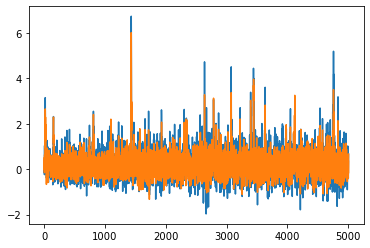

In [42]:
i = 44
fig, ax = plt.subplots()
ax.plot(session_dff[i,:])
ax.plot(master_dff[matched_master_ind[i],:])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  9., 38.]),
 array([0.08214458, 0.17350039, 0.26485619, 0.356212  , 0.44756781,
        0.53892361, 0.63027942, 0.72163522, 0.81299103, 0.90434683,
        0.99570264]),
 <BarContainer object of 10 artists>)

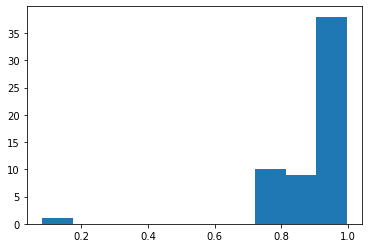

In [43]:
dff_cc = np.zeros(session_dff.shape[0])
for i in range(session_dff.shape[0]):
    dff_cc[i] = np.corrcoef(session_dff[i,:], master_dff[matched_master_ind[i],:])[0,1]
plt.hist(dff_cc)

In [44]:
np.where(dff_cc<0.5)

(array([38], dtype=int64),)

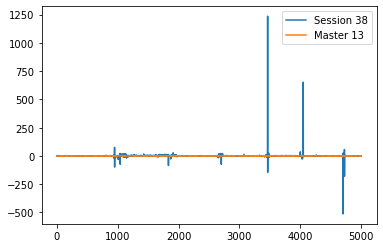

In [47]:
i = 38
fig, ax = plt.subplots()
ax.plot(session_dff[i,:], label=f'Session {i}')
ax.plot(master_dff[matched_master_ind[i],:], label=f'Master {matched_master_ind[i]}')
ax.legend()

In [48]:
# Test from a plane where there was merge
# See if the previous indexing was correct
mi = 0
mouse = mice[mi]
pn = 3
plane_dir = Path(f'{h5Dir}{mouse:03}/plane_{pn}/')
roi_collection = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
first_sn = selected_session_num[0]
first_from_master_dn = plane_dir / f'{first_sn:03d}/plane0/from_master_map/'
first_filtered_master_dn = plane_dir / f'{first_sn:03d}/plane0/filtered_master_map/'
if os.path.isdir(first_filtered_master_dn) != True:
    os.mkdir(first_filtered_master_dn)
first_from_master_stat = np.load(first_from_master_dn / 'stat.npy',allow_pickle=True)
first_from_master_iscell = np.load(first_from_master_dn / 'iscell.npy',allow_pickle=True)
'imerge' in first_from_master_stat[0].keys()

True

4


(array([ 1.,  0.,  0.,  1.,  1.,  0.,  8., 13., 30., 73.]),
 array([0.08937079, 0.18002716, 0.27068353, 0.3613399 , 0.45199626,
        0.54265263, 0.633309  , 0.72396537, 0.81462173, 0.9052781 ,
        0.99593447]),
 <BarContainer object of 10 artists>)

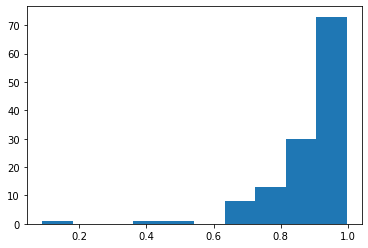

In [49]:
# Check if the master ROI map matches to the session FOV from suite2p GUI.
# Then,
# Check if the indices really match
si = 3
sn = selected_session_num[si]
print(sn)
session_dff = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/dff.npy', allow_pickle=True)

matched_master_ind = roi_collection['final_matching_master_roi_index_list'][si]

master_dff = np.load(plane_dir / f'{sn:03}/plane0/from_master_map/dff.npy', allow_pickle=True)

dff_cc = np.zeros(session_dff.shape[0])
for i in range(session_dff.shape[0]):
    dff_cc[i] = np.corrcoef(session_dff[i,:], master_dff[matched_master_ind[i],:])[0,1]
plt.hist(dff_cc)

In [50]:
np.where(dff_cc<0.5)

(array([104, 123, 124], dtype=int64),)

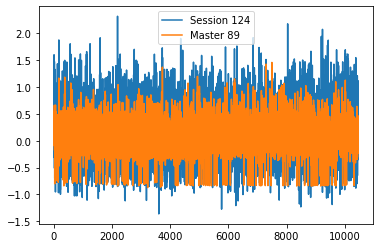

In [53]:
i = 124
fig, ax = plt.subplots()
ax.plot(session_dff[i,:], label=f'Session {i}')
ax.plot(master_dff[matched_master_ind[i],:], label=f'Master {matched_master_ind[i]}')
ax.legend()

In [54]:
np.sum([len(s['imerge']) for s in first_from_master_stat])

4

In [55]:
imerge = np.where([len(s['imerge']) for s in first_from_master_stat])[0] # merge outcome roi
all_merged_ind = []
for im in imerge:
    first_from_master_stat[im]['lam'] = np.ones_like(first_from_master_stat[im]['ypix']) / len(first_from_master_stat[im]['ypix'])
    merged_ind = first_from_master_stat[im]['imerge']
    all_merged_ind.extend(merged_ind)
all_merged_ind = np.array(all_merged_ind)
print(all_merged_ind)

[ 69  88 149 150]


In [57]:
# correct roi_collection['final_matching_master_roi_index_list']
# and save to JK0xx_planex_roi_collection_filtered.npy

from_master_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
filtered_master_dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
if os.path.isdir(filtered_master_dn) != True:
    os.mkdir(filtered_master_dn)
session_master_stat = np.load(from_master_dn / 'stat.npy', allow_pickle=True)
for im in imerge:
    merged_ind = first_from_master_stat[im]['imerge']
    merge_ypix = []
    merge_xpix = []
    for mii in merged_ind:
        merge_ypix.extend(session_master_stat[mii]['ypix'])
        merge_xpix.extend(session_master_stat[mii]['xpix'])
    merge_ypix = np.array(merge_ypix)
    merge_xpix = np.array(merge_xpix)
    merge_lam = np.ones_like(merge_ypix) / len(merge_ypix)
    merge_med = median_pix(merge_ypix, merge_xpix)
    new_roi = {'ypix': merge_ypix,
                'xpix': merge_xpix,
                'lam': merge_lam,
                'med': merge_med}
    session_master_stat = np.append(session_master_stat, new_roi)
# remove merged indices from session_stat and save it
session_filtered_master_stat = np.delete(session_master_stat, all_merged_ind)



In [75]:
session_ops = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/ops.npy', allow_pickle=True).item()
Ly = session_ops['Ly']
Lx = session_ops['Lx']
session_stat = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)

session_num_roi = len(session_stat)
session_roi_map = np.zeros((session_num_roi,Ly,Lx), dtype='bool')
for ri in range(session_num_roi):
    session_roi_map[ri, session_stat[ri]['ypix'], session_stat[ri]['xpix']] = 1

session_filtered_num_roi = len(session_filtered_master_stat)
session_filtered_master_roi_map = np.zeros((session_filtered_num_roi,Ly,Lx), dtype='bool')
for ri in range(session_filtered_num_roi):
    session_filtered_master_roi_map[ri, session_filtered_master_stat[ri]['ypix'], session_filtered_master_stat[ri]['xpix']] = 1

filtered_overlap_matrix = np.zeros((session_num_roi, session_filtered_num_roi))
for sri in range(session_num_roi):
    for fri in range(session_filtered_num_roi):
        filtered_overlap_matrix[sri,fri] = np.sum(session_roi_map[sri,:,:] * session_filtered_master_roi_map[fri,:,:])

filtered_matching_roi_ind = np.argmax(filtered_overlap_matrix,axis=1)
len(filtered_matching_roi_ind)

127

In [78]:
len(np.unique(filtered_matching_roi_ind))

126

In [81]:
np.where([len(np.where(filtered_matching_roi_ind==mri)[0])>1 for mri in np.unique(filtered_matching_roi_ind)])[0]

array([124], dtype=int64)

In [82]:
np.unique(filtered_matching_roi_ind)[124]

255

In [83]:
np.where(filtered_matching_roi_ind==255)[0]

array([ 71, 121], dtype=int64)

In [73]:
napari.view_image(session_filtered_master_roi_map);

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [28]:
# check the similarity of ROI location
session_filtered_master_stat[0].keys()

dict_keys(['ypix', 'xpix', 'lam', 'med', 'mrs', 'mrs0', 'compact', 'solidity', 'npix', 'npix_soma', 'soma_crop', 'overlap', 'radius', 'aspect_ratio', 'npix_norm_no_crop', 'npix_norm', 'footprint', 'skew', 'std', 'neuropil_mask', 'inmerge', 'yext', 'xext', 'ycirc', 'xcirc', 'imerge'])

In [189]:
# Test from single plane
# Copy iscell and stat from the first session of 'from_master_map',
# which is supposed to have manually curated master map
def median_pix(ypix, xpix):
    """ Copied from suite2p.detection
    For some reason I can't import it, while I can import roi_stats
    """
    ymed, xmed = np.median(ypix), np.median(xpix)
    imin = np.argmin((xpix-xmed)**2 + (ypix-ymed)**2)
    xmed = xpix[imin]
    ymed = ypix[imin]
    return [ymed, xmed]

def match_roi_with_filtered_master(session_stat, session_filtered_master_stat, Ly, Lx):
    session_num_roi = len(session_stat)
    session_roi_map = np.zeros((session_num_roi,Ly,Lx), dtype='bool')
    for ri in range(session_num_roi):
        session_roi_map[ri, session_stat[ri]['ypix'], session_stat[ri]['xpix']] = 1

    session_filtered_num_roi = len(session_filtered_master_stat)
    session_filtered_master_roi_map = np.zeros((session_filtered_num_roi,Ly,Lx), dtype='bool')
    for ri in range(session_filtered_num_roi):
        session_filtered_master_roi_map[ri, session_filtered_master_stat[ri]['ypix'], session_filtered_master_stat[ri]['xpix']] = 1

    filtered_overlap_matrix = np.zeros((session_num_roi, session_filtered_num_roi))
    for sri in range(session_num_roi):
        for fri in range(session_filtered_num_roi):
            filtered_overlap_matrix[sri,fri] = np.sum(session_roi_map[sri,:,:] * session_filtered_master_roi_map[fri,:,:])
    filtered_matching_roi_ind = np.argmax(filtered_overlap_matrix, axis=1)
    assert len(filtered_matching_roi_ind) == len(session_stat)
    return filtered_matching_roi_ind

def build_roi_stats(stats, ops):
    if 'aspect' in ops:
        dy, dx = int(ops['aspect'] * 10), 10
    else:
        d0 = ops['diameter']
        dy, dx = (d0, d0) if isinstance(d0, int) else d0
    stats = roi_stats(stats, dy = dy, dx = dx, Ly = ops['Ly'], Lx = ops['Lx'])
    return stats

mi = 0
mouse = mice[mi]
pn = 3
plane_dir = Path(f'{h5Dir}{mouse:03}/plane_{pn}/')
roi_collection = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
session_to_session_registration = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']
first_sn = selected_session_num[0]
first_from_master_dn = plane_dir / f'{first_sn:03d}/plane0/from_master_map/'
first_filtered_master_dn = plane_dir / f'{first_sn:03d}/plane0/filtered_master_map/'
if os.path.isdir(first_filtered_master_dn) != True:
    os.mkdir(first_filtered_master_dn)

first_session_ops = np.load(plane_dir / f'{first_sn:03}/plane0/equal_lam/ops.npy', allow_pickle=True).item()
Ly = session_ops['Ly']
Lx = session_ops['Lx']

first_stat = np.load(first_from_master_dn / 'stat.npy',allow_pickle=True)
first_iscell = np.load(first_from_master_dn / 'iscell.npy',allow_pickle=True)

# If there are merged ROIs, 
# correct iscell.npy and stat.npy (lam = 1/n)
# roi_collection['filtered_matching_master_roi_index_list']
# I have to remove ROIs merged into, to re-calculate signals from the merged ROIs (due to the overlap constraint)
# After re-assigning matching index, remove ROIs merged into. 
if np.sum([len(s['imerge']) for s in first_stat]) > 0: # There were merged cells during master ROI filtering
    # Modify stat in each session to have merged ROIs
    # Save stat.npy in each session.
    # Modify iscell.npy to remove ROIs merged into
    # Modify roi_collection to match indices between session ROI and master ROI

    # First, correct the lambda in stat.npy
    # and collect all merged indices (to remove from iscell and stat later)
    merge_out_ind = np.where([len(s['imerge']) for s in first_stat])[0]
    all_merged_ind = []
    for moi in merge_out_ind:
        first_stat[moi]['lam'] = np.ones_like(first_stat[moi]['ypix']) / len(first_stat[moi]['ypix'])
        merged_ind = first_stat[moi]['imerge']
        all_merged_ind.extend(merged_ind)
    all_merged_ind = np.array(all_merged_ind)
    
    # Apply merge in the rest of the sessions
    # Save the stat file after removing merged indices
    for sn in selected_session_num[1:]: # except for the first session stat
        from_master_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
        filtered_master_dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
        if os.path.isdir(filtered_master_dn) != True:
            os.mkdir(filtered_master_dn)
        session_stat = np.load(from_master_dn / 'stat.npy', allow_pickle=True)
        for moi in merge_out_ind:
            merged_ind = first_stat[moi]['imerge']
            merge_ypix = []
            merge_xpix = []
            for mi in merged_ind:
                merge_ypix.extend(session_stat[mi]['ypix'])
                merge_xpix.extend(session_stat[mi]['xpix'])
            merge_ypix = np.array(merge_ypix)
            merge_xpix = np.array(merge_xpix)
            # remove redundant pixel pairs
            merge_pix_pair = np.vstack((merge_ypix, merge_xpix))
            unique_pix_pair = np.unique(merge_pix_pair, axis=1)
            merge_ypix = unique_pix_pair[0,:]
            merge_xpix = unique_pix_pair[1,:]
            merge_lam = np.ones_like(merge_ypix) / len(merge_ypix)
            merge_med = median_pix(merge_ypix, merge_xpix)
            new_roi = {'ypix': merge_ypix,
                        'xpix': merge_xpix,
                        'lam': merge_lam,
                        'med': merge_med}
            session_stat = np.append(session_stat, new_roi)
        # remove merged indices from session_stat and save it
        session_stat = np.delete(session_stat, all_merged_ind)
        session_stat = build_roi_stats(session_stat, first_session_ops) # It requires 'diameter', 'aspect', 'Ly', and 'Lx', 
                                                    #which should be all the same, so it is OK to use first_session_ops
        np.save(filtered_master_dn / 'stat.npy', session_stat)
    # remove merged indices from iscell and stat
    first_iscell = np.delete(first_iscell, all_merged_ind, axis=0)
    first_stat = np.delete(first_stat, all_merged_ind)
    first_stat = build_roi_stats(first_stat, first_session_ops)
    np.save(first_filtered_master_dn / 'stat.npy', first_stat)

    # correct roi_collection['final_matching_master_roi_index_list']
    # and save to JK0xx_planex_roi_collection_filtered.npy
    filtered_matching_master_roi_index_list = []
    for i in range(len(selected_session_num)):
        sn = selected_session_num[i]
        session_stat = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)
        session_filtered_master_stat = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/stat.npy', allow_pickle=True)
        filtered_matching_roi_ind = match_roi_with_filtered_master(session_stat, session_filtered_master_stat, Ly, Lx)
        filtered_matching_master_roi_index_list.append(filtered_matching_roi_ind)
    roi_collection['filtered_matching_master_roi_index_list'] = filtered_matching_master_roi_index_list

else: # When there is no merge, stat does not need to change, so just copy them from
    # 'from_master_map' to 'filtered_master_map'
    roi_collection['filtered_matching_master_roi_index_list'] = roi_collection['final_matching_master_roi_index_list']
    for sn in selected_session_num:
        from_master_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
        filtered_master_dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
        if os.path.isdir(filtered_master_dn) != True:
            os.mkdir(filtered_master_dn)
        shutil.copy(from_master_dn / 'stat.npy', filtered_master_dn / 'stat.npy')
        
# Then, save the iscell.npy and ops.npy to each session
# For iscell.npy, all sessions should have the same
for sn in selected_session_num:
    dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
    np.save(dn / 'iscell.npy', first_iscell)
    from_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
    shutil.copy(from_dn / 'ops.npy', dn / 'ops.npy')
   
# If there is no merged ROIs, just copy JK0xx_planex_roi_collection_final.npy and save to JK0xx_planex_roi_collection_filtered.npy
# If there was merge, then the corrected roi_collection is saved to '..._roi_collection_filtered.npy'
np.save(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_filtered.npy', roi_collection)


In [185]:
selected_session_num

array([ 1,  2,  3,  4,  5,  6, 13, 15, 17, 19, 22, 23, 24])

In [190]:
roi_collection['filtered_matching_master_roi_index_list'][4]

array([ 89, 165, 227,  49, 203, 104,  90, 107, 166,  36,  34,  91, 206,
       185, 149, 208,  92, 236,  93, 152, 178,  16,  37, 140, 205,   1,
       231,  35, 256,  50, 202,  48, 229, 113,  40,  17,  21, 189, 109,
        38, 154,   3, 184,  53,  18,  94, 169,  47,   4, 211, 225, 183,
        56, 110, 144, 191, 151,  23, 159,  41, 188, 111, 106, 153,  95,
       255, 238, 237,  96, 214, 204, 218, 117,  39,  55, 172, 195,  43,
       127, 121,  97,   8, 212, 221,  22, 115,  98,  25, 209,  77,  99,
       100, 119,  59, 168, 101,  32, 240, 223, 136, 175, 128, 118, 102],
      dtype=int64)

In [ ]:
# Run signal extraction again from each session.
# Calculate dff as well.
# Try re-calculating them all, since I observed few cells with flat signal
for sn in selected_session_num:
    ops = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/ops.npy', allow_pickle=True).item()
    ops['reg_file'] = plane_dir / f'{sn:03}/plane0/data.bin'
    stat = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/stat.npy', allow_pickle=True)
    
    ops, stat, F, Fneu, _, _ = create_masks_and_extract(ops, stat)

    dF = F.copy() - ops['neucoeff']*Fneu
    dF, Flow = extraction.preprocess(
        F=dF,
        baseline=ops['baseline'],
        win_baseline=ops['win_baseline'],
        sig_baseline=ops['sig_baseline'],
        fs=ops['fs'],
        prctile_baseline=ops['prctile_baseline']
    )
    spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])
    dff = dF / Flow

    ops['save_path'] = plane_dir / f'{sn:03}/plane0/filtered_master_map/'
    fpath = ops['save_path']
    if os.path.isdir(fpath) != True:
        os.mkdir(fpath)
    np.save(os.path.join(fpath, 'ops.npy'), ops)
    np.save(os.path.join(fpath, 'stat.npy'), stat)
    np.save(os.path.join(fpath,'F.npy'), F)
    np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
    np.save(os.path.join(fpath, 'spks.npy'), spks)
    np.save(os.path.join(fpath, 'dff.npy'), dff)

In [201]:
# Check if the master ROI map matches to the session FOV from suite2p GUI.
# Then,
# Check if the indices really match
roi_collection = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_filtered.npy', allow_pickle=True).item()
session_to_session_registration = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
selected_session_num = session_to_session_registration['selected_session_num']

si = 8
sn = selected_session_num[si]

session_dff = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/dff.npy', allow_pickle=True)
session_stat = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)

matched_master_ind = roi_collection['filtered_matching_master_roi_index_list'][si]

master_dff = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/dff.npy', allow_pickle=True)
master_stat = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/stat.npy', allow_pickle=True)
print(sn)

17


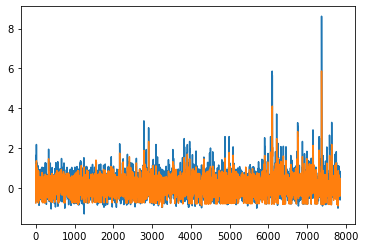

In [206]:
i = 23
fig, ax = plt.subplots()
ax.plot(session_dff[i,:])
ax.plot(master_dff[matched_master_ind[i],:])

# Run the whole mice and sessions

In [212]:
for mi in tqdm.tqdm_notebook(range(1,3)):
    mouse = mice[mi]
    for pn in tqdm.tqdm_notebook(range(1,9)):
        plane_dir = Path(f'{h5Dir}{mouse:03}/plane_{pn}/')
        roi_collection = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_final.npy', allow_pickle=True).item()
        session_to_session_registration = np.load(plane_dir / f'JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
        selected_session_num = session_to_session_registration['selected_session_num']
        first_sn = selected_session_num[0]
        first_from_master_dn = plane_dir / f'{first_sn:03d}/plane0/from_master_map/'
        first_filtered_master_dn = plane_dir / f'{first_sn:03d}/plane0/filtered_master_map/'
        if os.path.isdir(first_filtered_master_dn) != True:
            os.mkdir(first_filtered_master_dn)

        first_session_ops = np.load(plane_dir / f'{first_sn:03}/plane0/equal_lam/ops.npy', allow_pickle=True).item()
        Ly = session_ops['Ly']
        Lx = session_ops['Lx']

        first_stat = np.load(first_from_master_dn / 'stat.npy',allow_pickle=True)
        first_iscell = np.load(first_from_master_dn / 'iscell.npy',allow_pickle=True)

        merge_flag = False
        # If there are merged ROIs, 
        # correct iscell.npy and stat.npy (lam = 1/n)
        # roi_collection['filtered_matching_master_roi_index_list']
        # I have to remove ROIs merged into, to re-calculate signals from the merged ROIs (due to the overlap constraint)
        # After re-assigning matching index, remove ROIs merged into.
        if 'imerge' in first_stat[0].keys(): # There were merged cells during master ROI filtering            
        # if np.sum([len(s['imerge']) for s in first_stat]) > 0: # There were merged cells during master ROI filtering
            # Modify stat in each session to have merged ROIs
            # Save stat.npy in each session.
            # Modify iscell.npy to remove ROIs merged into
            # Modify roi_collection to match indices between session ROI and master ROI

            # First, correct the lambda in stat.npy
            # and collect all merged indices (to remove from iscell and stat later)
            merge_out_ind = np.where([len(s['imerge']) for s in first_stat])[0]
            if len(merge_out_ind) > 0:
                merge_flag = True
        
        if merge_flag:
            all_merged_ind = []
            for moi in merge_out_ind:
                first_stat[moi]['lam'] = np.ones_like(first_stat[moi]['ypix']) / len(first_stat[moi]['ypix'])
                merged_ind = first_stat[moi]['imerge']
                all_merged_ind.extend(merged_ind)
            all_merged_ind = np.array(all_merged_ind)
            
            # Apply merge in the rest of the sessions
            # Save the stat file after removing merged indices
            for sn in selected_session_num[1:]: # except for the first session stat
                from_master_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
                filtered_master_dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
                if os.path.isdir(filtered_master_dn) != True:
                    os.mkdir(filtered_master_dn)
                session_stat = np.load(from_master_dn / 'stat.npy', allow_pickle=True)
                for moi in merge_out_ind:
                    merged_ind = first_stat[moi]['imerge']
                    merge_ypix = []
                    merge_xpix = []
                    for mi in merged_ind:
                        merge_ypix.extend(session_stat[mi]['ypix'])
                        merge_xpix.extend(session_stat[mi]['xpix'])
                    merge_ypix = np.array(merge_ypix)
                    merge_xpix = np.array(merge_xpix)
                    # remove redundant pixel pairs
                    merge_pix_pair = np.vstack((merge_ypix, merge_xpix))
                    unique_pix_pair = np.unique(merge_pix_pair, axis=1)
                    merge_ypix = unique_pix_pair[0,:]
                    merge_xpix = unique_pix_pair[1,:]
                    merge_lam = np.ones_like(merge_ypix) / len(merge_ypix)
                    merge_med = median_pix(merge_ypix, merge_xpix)
                    new_roi = {'ypix': merge_ypix,
                                'xpix': merge_xpix,
                                'lam': merge_lam,
                                'med': merge_med}
                    session_stat = np.append(session_stat, new_roi)
                # remove merged indices from session_stat and save it
                session_stat = np.delete(session_stat, all_merged_ind)
                session_stat = build_roi_stats(session_stat, first_session_ops) # It requires 'diameter', 'aspect', 'Ly', and 'Lx', 
                                                            #which should be all the same, so it is OK to use first_session_ops
                np.save(filtered_master_dn / 'stat.npy', session_stat)
            # remove merged indices from iscell and stat
            first_iscell = np.delete(first_iscell, all_merged_ind, axis=0)
            first_stat = np.delete(first_stat, all_merged_ind)
            first_stat = build_roi_stats(first_stat, first_session_ops)
            np.save(first_filtered_master_dn / 'stat.npy', first_stat)

            # correct roi_collection['final_matching_master_roi_index_list']
            # and save to JK0xx_planex_roi_collection_filtered.npy
            filtered_matching_master_roi_index_list = []
            for i in range(len(selected_session_num)):
                sn = selected_session_num[i]
                session_stat = np.load(plane_dir / f'{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)
                session_filtered_master_stat = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/stat.npy', allow_pickle=True)
                filtered_matching_roi_ind = match_roi_with_filtered_master(session_stat, session_filtered_master_stat, Ly, Lx)
                filtered_matching_master_roi_index_list.append(filtered_matching_roi_ind)
            roi_collection['filtered_matching_master_roi_index_list'] = filtered_matching_master_roi_index_list

        else: # When there is no merge, stat does not need to change, so just copy them from
            # 'from_master_map' to 'filtered_master_map'
            roi_collection['filtered_matching_master_roi_index_list'] = roi_collection['final_matching_master_roi_index_list']
            for sn in selected_session_num:
                from_master_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
                filtered_master_dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
                if os.path.isdir(filtered_master_dn) != True:
                    os.mkdir(filtered_master_dn)
                shutil.copy(from_master_dn / 'stat.npy', filtered_master_dn / 'stat.npy')
                
        # Then, save the iscell.npy and ops.npy to each session
        # For iscell.npy, all sessions should have the same
        for sn in selected_session_num:
            dn = plane_dir / f'{sn:03d}/plane0/filtered_master_map/'
            np.save(dn / 'iscell.npy', first_iscell)
            from_dn = plane_dir / f'{sn:03d}/plane0/from_master_map/'
            shutil.copy(from_dn / 'ops.npy', dn / 'ops.npy')
        
        # If there is no merged ROIs, just copy JK0xx_planex_roi_collection_final.npy and save to JK0xx_planex_roi_collection_filtered.npy
        # If there was merge, then the corrected roi_collection is saved to '..._roi_collection_filtered.npy'
        np.save(plane_dir / f'JK{mouse:03}_plane{pn}_roi_collection_filtered.npy', roi_collection)

        # Run signal extraction again from each session.
        # Calculate dff as well.
        # Try re-calculating them all, since I observed few cells with flat signal
        for sn in selected_session_num:
            ops = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/ops.npy', allow_pickle=True).item()
            ops['reg_file'] = plane_dir / f'{sn:03}/plane0/data.bin'
            stat = np.load(plane_dir / f'{sn:03}/plane0/filtered_master_map/stat.npy', allow_pickle=True)
            
            ops, stat, F, Fneu, _, _ = create_masks_and_extract(ops, stat)

            dF = F.copy() - ops['neucoeff']*Fneu
            dF, Flow = extraction.preprocess(
                F=dF,
                baseline=ops['baseline'],
                win_baseline=ops['win_baseline'],
                sig_baseline=ops['sig_baseline'],
                fs=ops['fs'],
                prctile_baseline=ops['prctile_baseline']
            )
            spks = extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])
            dff = dF / Flow

            ops['save_path'] = plane_dir / f'{sn:03}/plane0/filtered_master_map/'
            fpath = ops['save_path']
            if os.path.isdir(fpath) != True:
                os.mkdir(fpath)
            np.save(os.path.join(fpath, 'ops.npy'), ops)
            np.save(os.path.join(fpath, 'stat.npy'), stat)
            np.save(os.path.join(fpath,'F.npy'), F)
            np.save(os.path.join(fpath,'Fneu.npy'), Fneu)
            np.save(os.path.join(fpath, 'spks.npy'), spks)
            np.save(os.path.join(fpath, 'dff.npy'), dff)

C:\Users\shires\AppData\Local\Temp/ipykernel_48416/2308498233.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mi in tqdm.tqdm_notebook(range(1,3)):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\shires\AppData\Local\Temp/ipykernel_48416/2308498233.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pn in tqdm.tqdm_notebook(range(1,9)):


  0%|          | 0/8 [00:00<?, ?it/s]

Masks created, 2.21 sec.
Extracted fluorescence from 210 ROIs in 13320 frames, 28.89 sec.
Masks created, 1.87 sec.
Extracted fluorescence from 210 ROIs in 11545 frames, 19.09 sec.
Masks created, 1.69 sec.
Extracted fluorescence from 210 ROIs in 9132 frames, 14.55 sec.
Masks created, 1.74 sec.
Extracted fluorescence from 210 ROIs in 12320 frames, 20.08 sec.
Masks created, 1.85 sec.
Extracted fluorescence from 210 ROIs in 10009 frames, 16.83 sec.
Masks created, 1.83 sec.
Extracted fluorescence from 210 ROIs in 7032 frames, 11.72 sec.
Masks created, 1.83 sec.
Extracted fluorescence from 210 ROIs in 5903 frames, 10.13 sec.
Masks created, 1.63 sec.
Extracted fluorescence from 210 ROIs in 14250 frames, 22.03 sec.
Masks created, 2.10 sec.
Extracted fluorescence from 283 ROIs in 13320 frames, 66.00 sec.
Masks created, 1.98 sec.
Extracted fluorescence from 283 ROIs in 11545 frames, 73.80 sec.
Masks created, 2.08 sec.
Extracted fluorescence from 283 ROIs in 9132 frames, 39.71 sec.
Masks created,

  0%|          | 0/8 [00:00<?, ?it/s]

Masks created, 1.40 sec.
Extracted fluorescence from 172 ROIs in 9747 frames, 48.05 sec.
Masks created, 1.51 sec.
Extracted fluorescence from 172 ROIs in 9164 frames, 39.21 sec.
Masks created, 1.43 sec.
Extracted fluorescence from 172 ROIs in 9148 frames, 41.20 sec.
Masks created, 1.40 sec.
Extracted fluorescence from 172 ROIs in 8981 frames, 38.02 sec.
Masks created, 1.47 sec.
Extracted fluorescence from 172 ROIs in 10015 frames, 45.88 sec.
Masks created, 1.37 sec.
Extracted fluorescence from 172 ROIs in 5466 frames, 27.79 sec.
Masks created, 1.39 sec.
Extracted fluorescence from 172 ROIs in 5209 frames, 24.20 sec.
Masks created, 1.45 sec.
Extracted fluorescence from 172 ROIs in 6135 frames, 26.62 sec.
Masks created, 1.49 sec.
Extracted fluorescence from 172 ROIs in 6542 frames, 27.82 sec.
Masks created, 1.46 sec.
Extracted fluorescence from 172 ROIs in 6479 frames, 27.26 sec.
Masks created, 1.51 sec.
Extracted fluorescence from 172 ROIs in 13403 frames, 57.25 sec.
Masks created, 1.49

# Signal QC
Copying QC code from 220821_roi_match_back.ipynb

In [214]:
# Collect correlation coefficient from all the sessions
# Save the results for each plane (gather all session values to the plane)
for mi in tqdm.notebook.tqdm(range(3)):
    mouse = mice[mi]
    for pn in tqdm.notebook.tqdm(range(1,9)):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        roi_collection = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_roi_collection_filtered.npy', allow_pickle=True).item()
        session_to_session_registration = np.load(f'{planeDir}JK{mouse:03}_plane{pn}_session_to_session_registration.npy', allow_pickle=True).item()
        selected_session_num = session_to_session_registration['selected_session_num']

        F_plane = []
        for si in range(len(selected_session_num)):
            sn = selected_session_num[si]
            matching_master_roi_index = roi_collection['filtered_matching_master_roi_index_list'][si]
            F_master = np.load(f'{planeDir}{sn:03}/plane0/filtered_master_map/F.npy', allow_pickle=True)
            F_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/F.npy', allow_pickle=True)
            stat_session = np.load(f'{planeDir}{sn:03}/plane0/equal_lam/stat.npy', allow_pickle=True)
            if 'imerge' in stat_session[0].keys():
                for s in stat_session:
                    s['imerge'] = []
            np.save(f'{planeDir}{sn:03}/plane0/equal_lam/stat.npy', stat_session)

            F_cc_session = np.zeros(len(matching_master_roi_index))
            for ri in range(len(matching_master_roi_index)):
                master_ind = matching_master_roi_index[ri]
                roi_F_session = F_session[ri]
                matched_roi_F_master = F_master[master_ind]
                F_cc_session[ri] = np.corrcoef(roi_F_session, matched_roi_F_master)[0,1]
            F_plane.append(F_cc_session)

        save_fn = f'{planeDir}roi_collection_filtered_qc_F_cc.npy'
        np.save(save_fn, F_plane)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

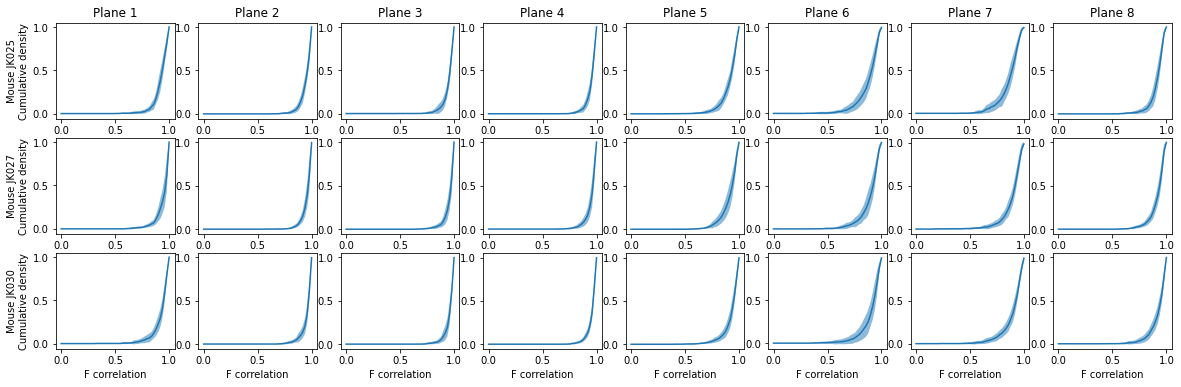

In [215]:
# Plot the distribution of correlation coefficients
fig, ax = plt.subplots(3,8,figsize=(20,6))
hist_bins = np.concatenate((np.array([-1]),(np.linspace(0,1,50))))
total_hist = []
total_cc = []
num_sessions = []
num_rois = []
for mi in range(3):
    mouse = mice[mi]
    for pn in range(1,9):
        planeDir = f'{h5Dir}{mouse:03}/plane_{pn}/'
        qc_F_cc = np.load(f'{planeDir}roi_collection_filtered_qc_F_cc.npy',allow_pickle=True)
        num_sessions.append(len(qc_F_cc))        
        plane_hist = np.zeros((len(qc_F_cc),len(hist_bins)-1))
        for i, cc in enumerate(qc_F_cc):
            plane_hist[i,:] = np.cumsum(np.histogram(cc, bins=hist_bins)[0]/len(cc))
            num_rois.append(len(cc))
            total_cc.extend(cc)
        total_hist.extend(plane_hist)
        ax[mi,pn-1].plot(hist_bins[1:],np.mean(plane_hist,axis=0))
        ax[mi,pn-1].fill_between(hist_bins[1:], np.mean(plane_hist,axis=0)-np.std(plane_hist,axis=0), np.mean(plane_hist,axis=0)+np.std(plane_hist,axis=0), alpha=0.5)
        if mi == 0:
            ax[mi,pn-1].set_title(f'Plane {pn}')
        if pn == 1:
            ax[mi,pn-1].set_ylabel(f'Mouse JK{mouse:03}\nCumulative density')
        if mi == 2:
            ax[mi,pn-1].set_xlabel('F correlation')
total_cc = np.array(total_cc)

Text(0.5, 1.0, '95% of ROIs have DFF correlation > 0.755')

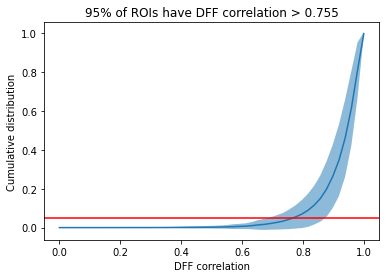

In [216]:
mean_hist = np.mean(np.array(total_hist),axis=0)
std_hist = np.std(np.array(total_hist),axis=0)
fig, ax = plt.subplots()
ax.plot(hist_bins[1:],mean_hist)
ax.fill_between(hist_bins[1:], mean_hist-std_hist, mean_hist+std_hist, alpha=0.5)
ax.axhline(0.05,color='r')
ax.set_xlabel('DFF correlation')
ax.set_ylabel('Cumulative distribution')
over_5 = hist_bins[np.where(mean_hist>0.05)[0][0]]
ax.set_title(f'95% of ROIs have DFF correlation > {over_5:.3}')